# Laboratorio 4 - Responsible AI
## SHAP con un modelo cualquiera
### Integrantes:
* Mario Guerra - 21008
* Javier Alvarado - 21188

In [1]:
# Instalación
!pip install torch torchvision pillow numpy matplotlib shap opencv-python

  Using cached torch-2.8.0-cp311-cp311-win_amd64.whl.metadata (30 kB)
  Using cached torchvision-0.23.0-cp311-cp311-win_amd64.whl.metadata (6.1 kB)
  Using cached pillow-11.3.0-cp311-cp311-win_amd64.whl.metadata (9.2 kB)
  Using cached matplotlib-3.10.6-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached shap-0.48.0-cp311-cp311-win_amd64.whl.metadata (25 kB)
  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
  Using cached filelock-3.19.1-py3-none-any.whl.metadata (2.1 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.9.0-py3-none-any.whl.metadata (10 kB)
  Using cached contourpy-1.3.3-cp311-cp311-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.59.2-cp311-cp311-win_amd64.whl.metadata (111 kB)
  Using cached kiwi

### Configuración de utilidades

In [2]:
# === Imports ===
import os, io, urllib.request
import numpy as np
import torch
import torch.nn.functional as F
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from PIL import Image
import matplotlib.pyplot as plt
import shap

# === Config general ===
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OUT_DIR = "outputs_shap"
os.makedirs(OUT_DIR, exist_ok=True)

# Estadísticos de normalización ImageNet
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)

# Utilidad: cargar imagen desde ruta local o URL
def load_rgb_image(path_or_url, size=224):
    """Carga una imagen RGB y la reescala cuadrada a 224x224."""
    if path_or_url.startswith("http://") or path_or_url.startswith("https://"):
        with urllib.request.urlopen(path_or_url) as r:
            img = Image.open(io.BytesIO(r.read())).convert("RGB")
    else:
        img = Image.open(path_or_url).convert("RGB")
    img = img.resize((size, size), Image.BICUBIC)
    return img

# Utilidad: convierte PIL->numpy [0,1] HWC
def pil_to_nhwc01(img_pil):
    x = np.array(img_pil).astype("float32") / 255.0
    return x  # (H,W,3) en [0,1]


c:\Users\mague\Downloads\Lab4RESPAI\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Carga del modelo

In [3]:
# Carga de pesos y categorías usando la API moderna de torchvision
weights = MobileNet_V2_Weights.IMAGENET1K_V1
model = mobilenet_v2(weights=weights).to(DEVICE).eval()
imagenet_labels = weights.meta["categories"]

# Predicción por lotes: recibe batch NHWC [0,1], normaliza y retorna probabilidades (numpy)
@torch.no_grad()
def batch_predict_nhwc01(nhwc_batch: np.ndarray) -> np.ndarray:
    """
    nhwc_batch: array float32 de forma (N,H,W,3) con valores en [0,1].
    Retorna: probabilidades softmax (N,1000) como numpy.
    """
    x = torch.from_numpy(nhwc_batch).permute(0,3,1,2).to(DEVICE)  # NCHW
    x = (x - IMAGENET_MEAN.to(DEVICE)) / IMAGENET_STD.to(DEVICE)
    logits = model(x)
    probs = F.softmax(logits, dim=1).detach().cpu().numpy()
    return probs

def topk_from_probs(probs_row: np.ndarray, k=5):
    idx = np.argsort(probs_row)[::-1][:k]
    return [(int(i), float(probs_row[i]), imagenet_labels[i]) for i in idx]


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\mague/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:01<00:00, 11.7MB/s]


### 2. Carga de imágenes

In [4]:
image_sources = [
    "data/avion.jpg",
    "data/gallo.jpg",
    "data/gorras.jpg"
]

# Carga y convierte a NHWC [0,1]
images_pil = [load_rgb_image(src, size=224) for src in image_sources]
images_nhwc01 = np.stack([pil_to_nhwc01(img) for img in images_pil], axis=0)  # (N,224,224,3)

len(images_pil), images_nhwc01.shape


(3, (3, 224, 224, 3))

### 3. Predicciones

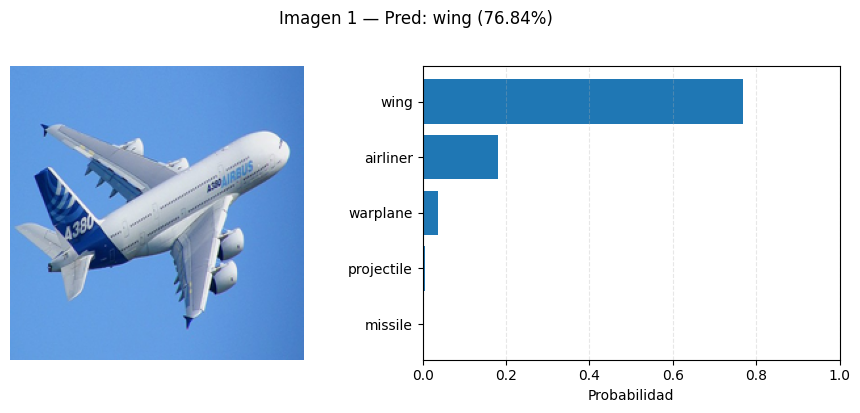


Imagen 1: data/avion.jpg
   1) wing                                      prob=0.7684
   2) airliner                                  prob=0.1811
   3) warplane                                  prob=0.0370
   4) projectile                                prob=0.0059
   5) missile                                   prob=0.0041


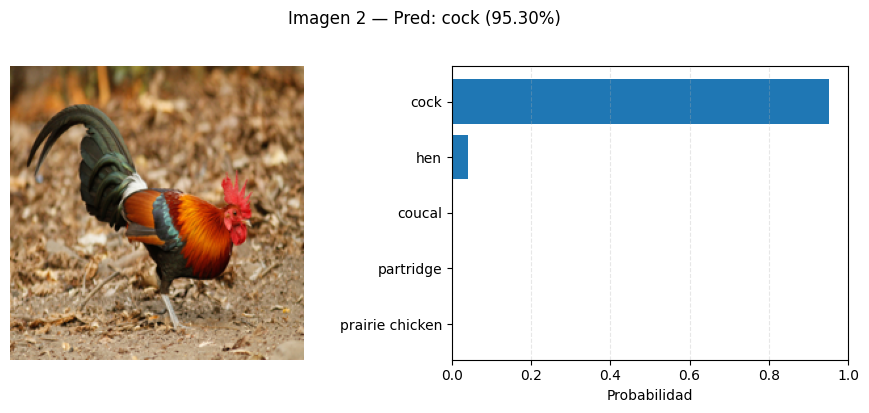


Imagen 2: data/gallo.jpg
   1) cock                                      prob=0.9530
   2) hen                                       prob=0.0418
   3) coucal                                    prob=0.0012
   4) partridge                                 prob=0.0012
   5) prairie chicken                           prob=0.0007


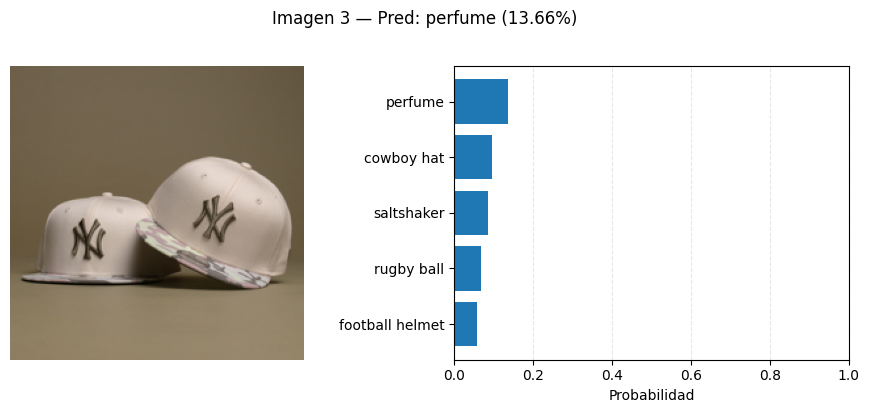


Imagen 3: data/gorras.jpg
   1) perfume                                   prob=0.1366
   2) cowboy hat                                prob=0.0964
   3) saltshaker                                prob=0.0862
   4) rugby ball                                prob=0.0683
   5) football helmet                           prob=0.0581


In [7]:
probs = batch_predict_nhwc01(images_nhwc01)

for idx, (img_pil, pr) in enumerate(zip(images_pil, probs), start=1):
    top5 = topk_from_probs(pr, k=5)

    # --- Figura: imagen + barras horizontales del top-5 ---
    fig, (ax_img, ax_bar) = plt.subplots(
        1, 2, figsize=(9, 4), gridspec_kw={'width_ratios': [1.1, 1.3]}
    )

    # Columna izquierda: imagen
    ax_img.imshow(img_pil)
    ax_img.axis("off")

    # Columna derecha: barras del top-5 (ordenadas de menor a mayor para que la más alta quede arriba)
    names   = [name for _, _, name in top5][::-1]
    probs5  = [p for _, p, _ in top5][::-1]
    ax_bar.barh(range(len(top5)), probs5)
    ax_bar.set_yticks(range(len(top5)))
    ax_bar.set_yticklabels(names)
    ax_bar.set_xlim(0, 1.0)
    ax_bar.set_xlabel("Probabilidad")
    ax_bar.grid(axis="x", linestyle="--", alpha=0.3)

    pred_name = top5[0][2]
    pred_prob = top5[0][1]
    fig.suptitle(f"Imagen {idx} — Pred: {pred_name} ({pred_prob:.2%})", y=1.02)

    plt.tight_layout()
    out_pred = os.path.join(OUT_DIR, f"pred_img{idx}.png")
    plt.savefig(out_pred, dpi=150, bbox_inches="tight")
    plt.show()

    # (Opcional) también imprime en texto en consola
    print(f"\nImagen {idx}: {image_sources[idx-1]}")
    for rank, (cls_idx, p, name) in enumerate(top5, start=1):
        print(f"  {rank:>2}) {name:40s}  prob={p:.4f}")

### 4. Explicación de predicciones con SHAP

PartitionExplainer explainer: 4it [04:57, 99.28s/it]                       


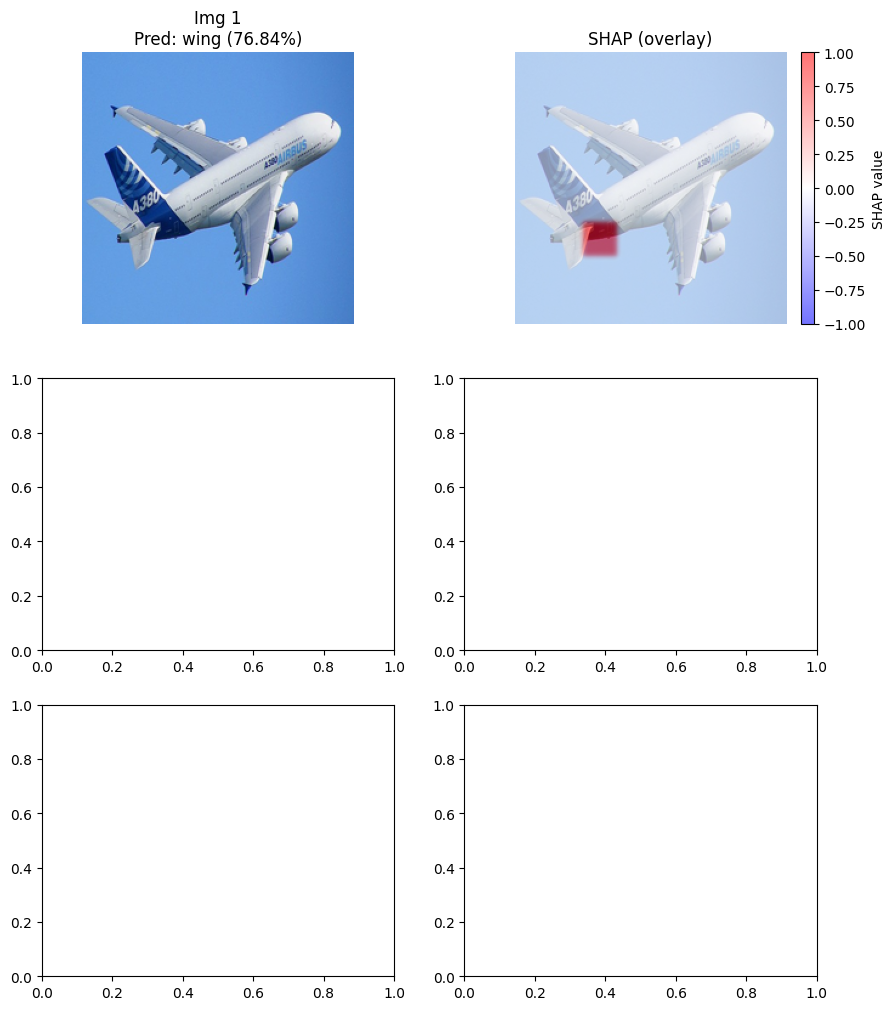

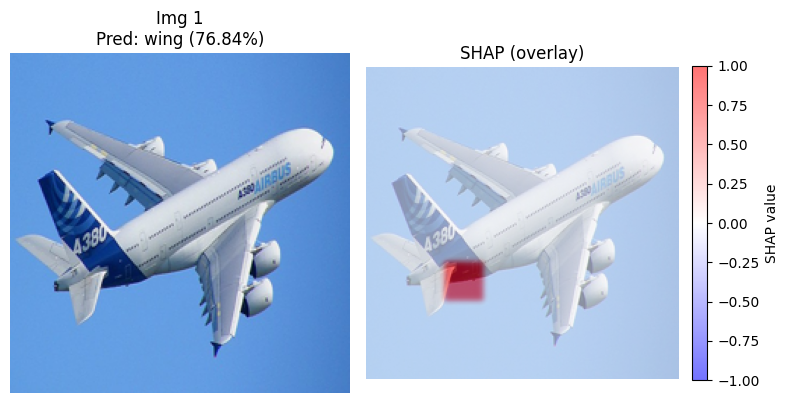

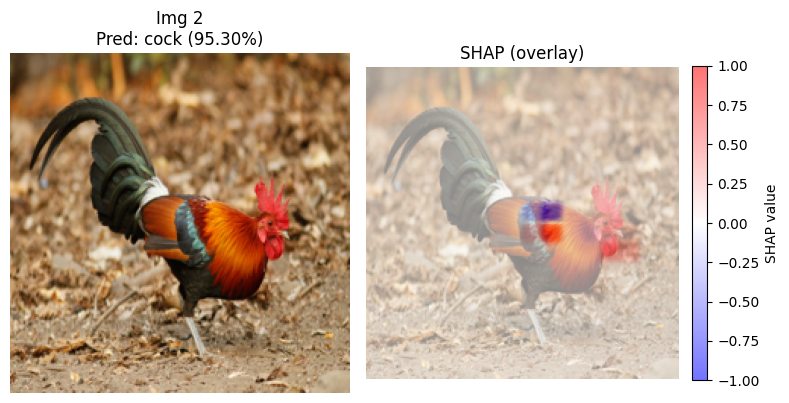

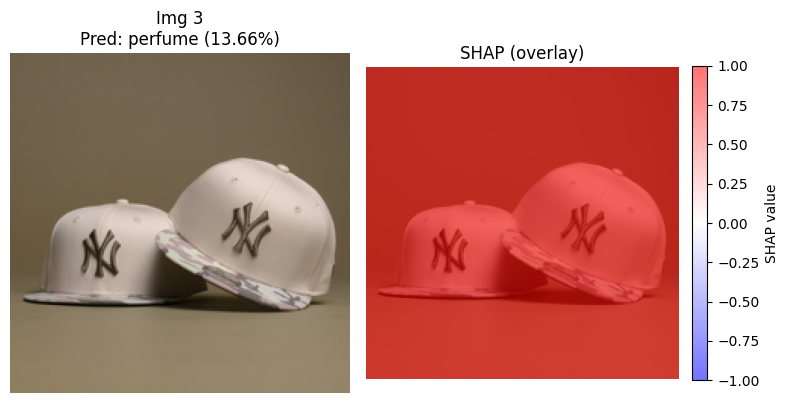

<Figure size 640x480 with 0 Axes>

Listo: figuras SHAP guardadas en outputs_shap (por imagen y panel general).


In [8]:
masker = shap.maskers.Image("inpaint_telea", (224, 224, 3))
explainer = shap.Explainer(
    batch_predict_nhwc01,
    masker,
    output_names=imagenet_labels,
    algorithm="partition"
)

# Explicamos hasta 3 imágenes (o menos si cargaste menos)
idx_to_explain = list(range(min(3, len(images_pil))))
to_explain = images_nhwc01[idx_to_explain]

# Más presupuesto para mejor calidad del árbol de particiones
shap_values = explainer(to_explain, max_evals=1000, batch_size=20)

def _explanation_array(expl, local_i):
    """
    Devuelve un mapa HxW con la suma de contribuciones en canales (más estable visualmente).
    Soporta tanto expl.values[local_i] como expl[local_i].values según la versión de SHAP.
    """
    try:
        vals = expl.values[local_i]          # (H,W,3) o (H,W,3,C)
    except Exception:
        vals = expl[local_i].values

    # Si trae dimensión de clases al final, nos quedamos con la clase predicha
    if vals.ndim == 4 and vals.shape[-1] > 3:
        # usar la clase predicha de esa imagen
        pred_idx = int(np.argmax(probs[idx_to_explain[local_i]]))
        vals = vals[..., pred_idx]  # (H,W,3)

    # Sumamos en canales para un mapa único HxW
    if vals.shape[-1] == 3:
        vals = vals.sum(axis=-1)  # (H,W)

    return vals

# Panel general: por cada imagen, mostramos original + overlay SHAP
rows = len(idx_to_explain)
fig_panel, axes = plt.subplots(rows, 2, figsize=(10, 4*rows))

if rows == 1:
    axes = np.array([axes])  # uniformizar acceso

for local_i, global_idx in enumerate(idx_to_explain):
    img = images_nhwc01[global_idx]
    p = probs[global_idx]
    pred_idx = int(np.argmax(p))
    pred_name = imagenet_labels[pred_idx]
    pred_prob = float(p[pred_idx])

    # --- Subplot 1: original + etiqueta ---
    ax1 = axes[local_i, 0]
    ax1.imshow(img)
    ax1.axis("off")
    ax1.set_title(f"Img {global_idx+1}\nPred: {pred_name} ({pred_prob:.2%})")

    # --- Subplot 2: heatmap SHAP overlay ---
    ax2 = axes[local_i, 1]

    # Intenta usar la API moderna directamente
    try:
        shap.plots.image(shap_values[local_i], ax=ax2, show=False)
        ax2.set_title("SHAP (Partition)")
    except Exception:
        # Fallback: overlay manual con mejor contraste y suavizado
        phi = _explanation_array(shap_values, local_i)  # (H,W)
        m = float(np.abs(phi).max()) or 1e-9
        phi_n = phi / m

        # Suavizado para heatmap más limpio
        import cv2
        phi_blur = cv2.GaussianBlur(phi_n, (11, 11), 0)

        ax2.imshow(img)
        hm = ax2.imshow(phi_blur, cmap="bwr", alpha=0.55, vmin=-1, vmax=1)
        ax2.axis("off")
        ax2.set_title("SHAP (overlay)")
        cbar = fig_panel.colorbar(hm, ax=ax2, fraction=0.046, pad=0.04)
        cbar.set_label("SHAP value")

    # Guardado individual por imagen (combo original + SHAP)
    fig_single, ax_single = plt.subplots(1, 2, figsize=(8, 4))
    ax_single[0].imshow(img); ax_single[0].axis("off")
    ax_single[0].set_title(f"Img {global_idx+1}\nPred: {pred_name} ({pred_prob:.2%})")
    try:
        shap.plots.image(shap_values[local_i], ax=ax_single[1], show=False)
        ax_single[1].set_title("SHAP (Partition)")
    except Exception:
        phi = _explanation_array(shap_values, local_i)
        m = float(np.abs(phi).max()) or 1e-9
        phi_n = phi / m
        import cv2
        phi_blur = cv2.GaussianBlur(phi_n, (11, 11), 0)
        ax_single[1].imshow(img)
        hm = ax_single[1].imshow(phi_blur, cmap="bwr", alpha=0.55, vmin=-1, vmax=1)
        ax_single[1].axis("off")
        ax_single[1].set_title("SHAP (overlay)")
        plt.colorbar(hm, ax=ax_single[1], fraction=0.046, pad=0.04, label="SHAP value")

    plt.tight_layout()
    out_combo = os.path.join(OUT_DIR, f"shap_combo_img{global_idx+1}.png")
    fig_single.savefig(out_combo, dpi=150, bbox_inches="tight")
    plt.show()
    plt.close(fig_single)

plt.tight_layout()
out_panel = os.path.join(OUT_DIR, "shap_panel_3imgs.png")
fig_panel.savefig(out_panel, dpi=150, bbox_inches="tight")
plt.show()
plt.close(fig_panel)

print(f"Listo: figuras SHAP guardadas en {OUT_DIR} (por imagen y panel general).")

### 5. Reflexión

